# Mostrar todas las imagenes a usar

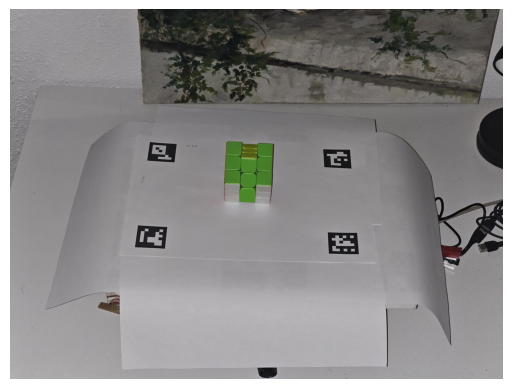

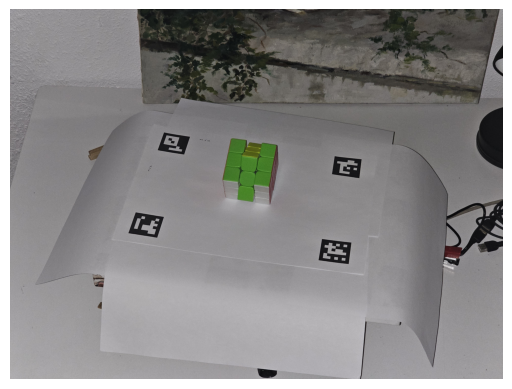

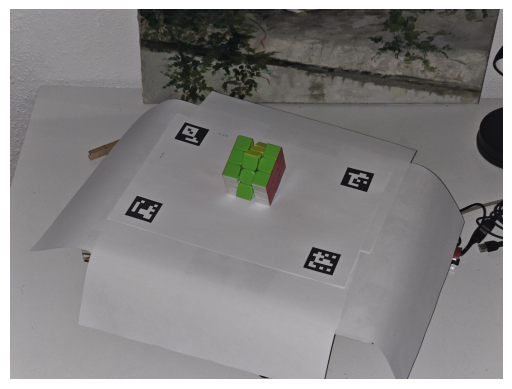

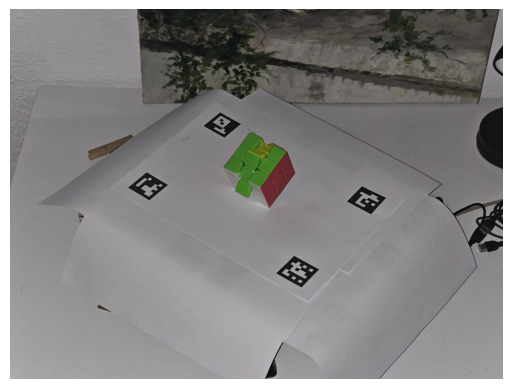

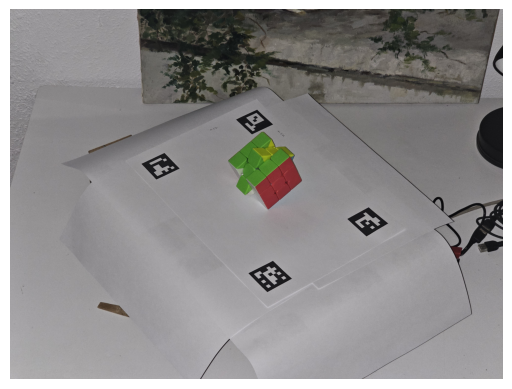

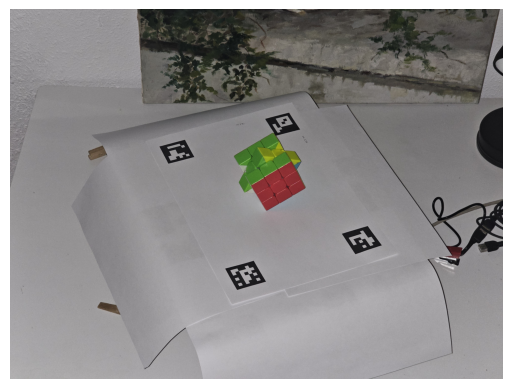

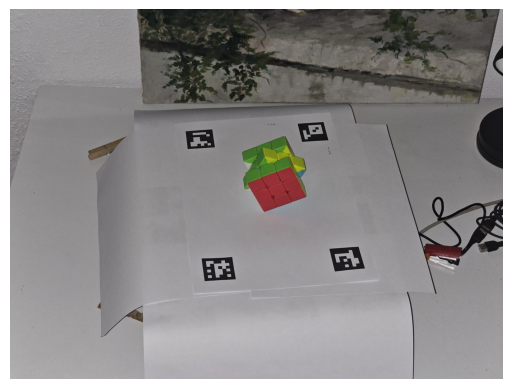

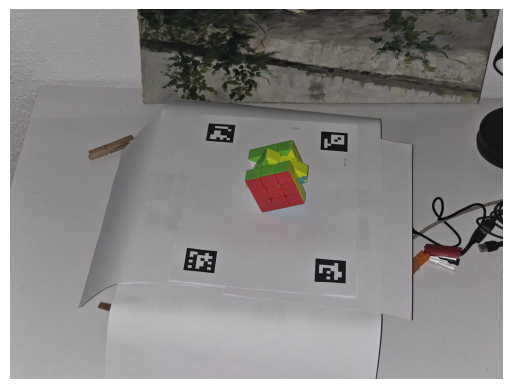

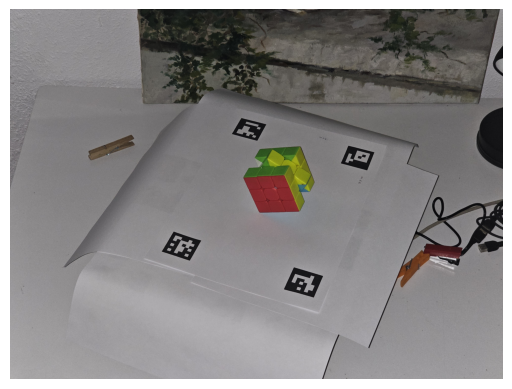

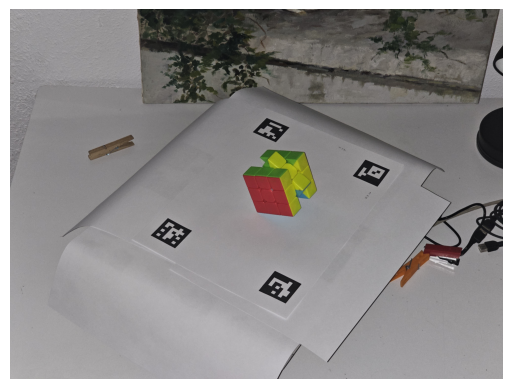

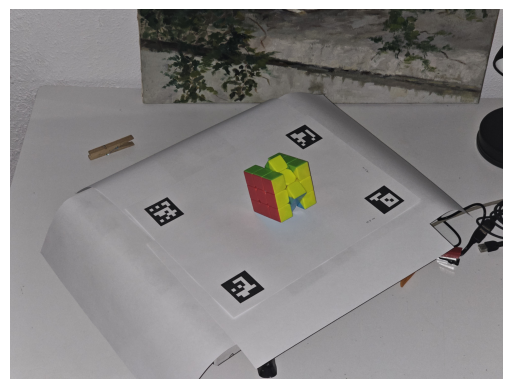

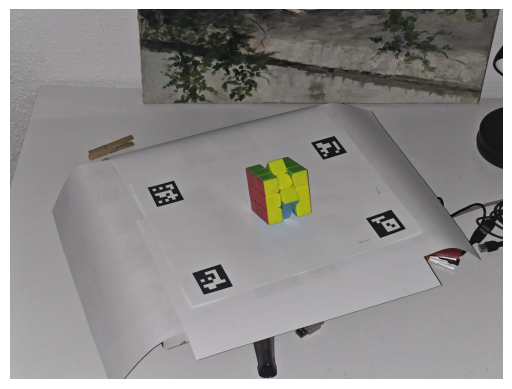

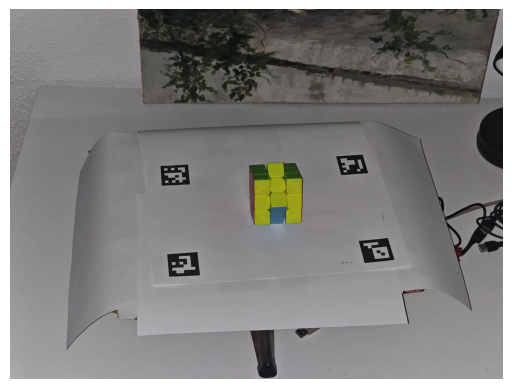

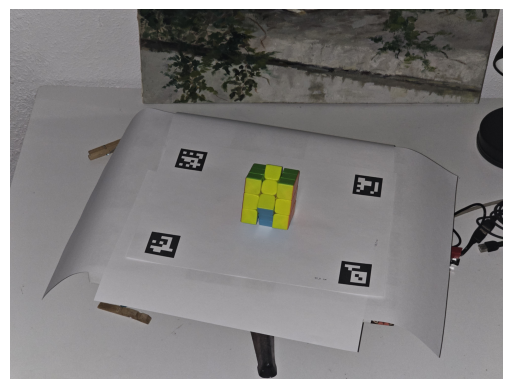

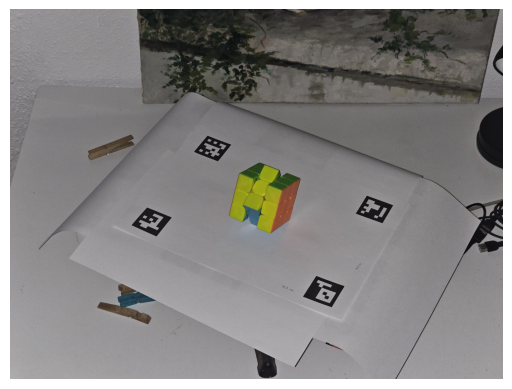

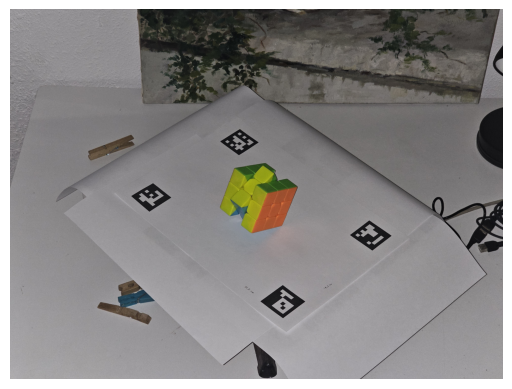

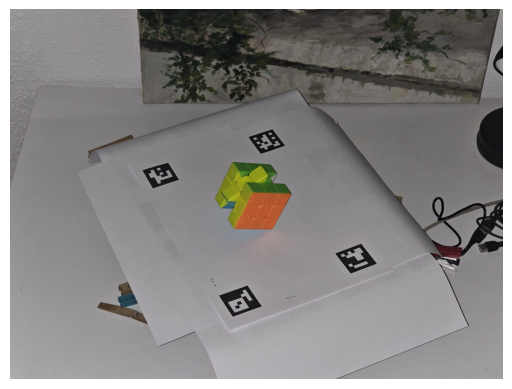

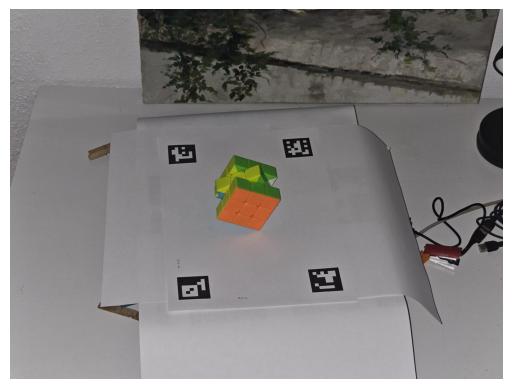

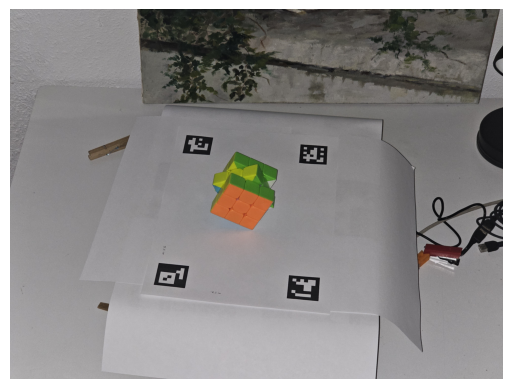

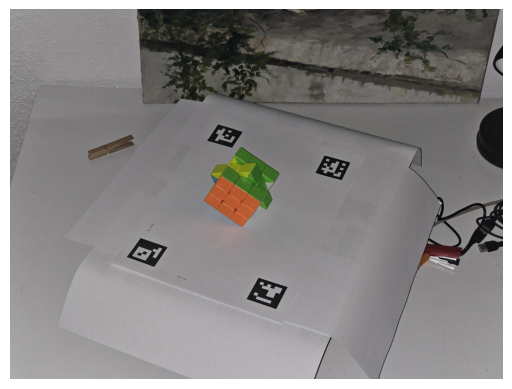

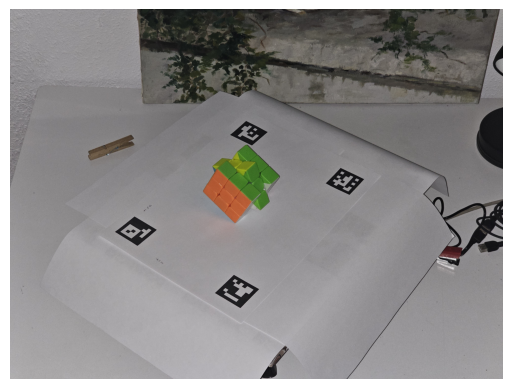

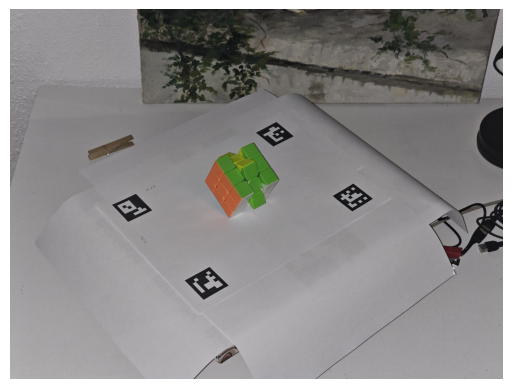

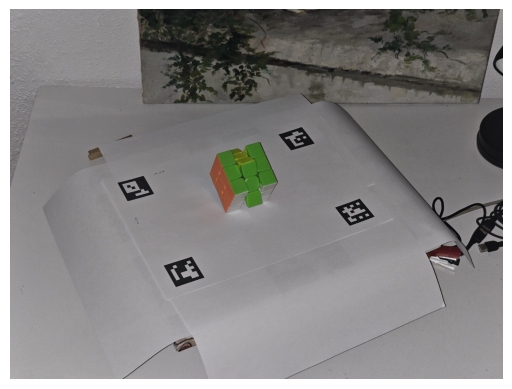

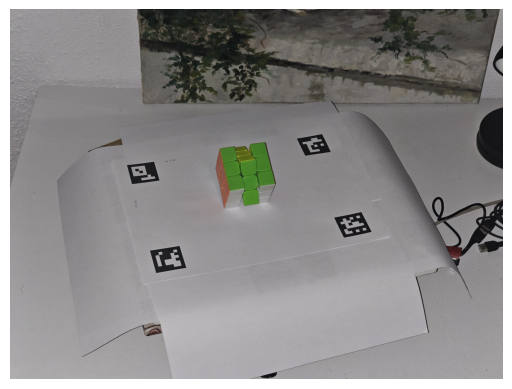

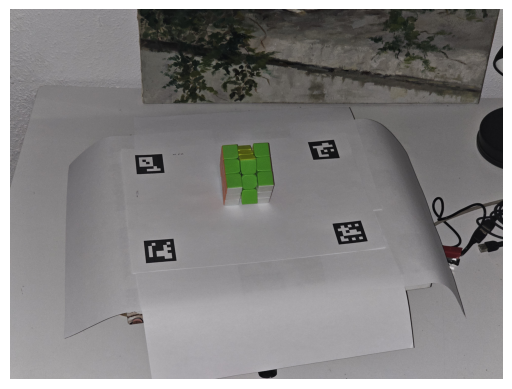

In [1]:
import matplotlib.pyplot as plt
import glob
import numpy as np  # Import numpy for array manipulation

# Specify the path to the images
images_paths = glob.glob('img/v2/pid-cube/*.jpg')

# Loop through all the image paths in the list
plt.figure()
for file_name in images_paths:
    img = plt.imread(file_name)      # Read the image file directly into an array
    img = np.flipud(img)             # Flip the image in the up/down direction
    plt.imshow(img)                  # Display the image
    plt.axis('off')                  # Remove the axes
    plt.show()                       # Show the image


# FUNCIÓN DE CALIBRADO

In [1]:
def calibrate_from_template(template, show_image=False):

        objpoints = []
        imgpoints = []
        for plantilla in glob.glob(template):
            try:
                # Lectura de la imagen
                frame = cv2.imread(plantilla)
                
                # Aplicación de ArUco
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
                parameters =  aruco.DetectorParameters()
                detector = aruco.ArucoDetector(aruco_dict, parameters)
                corners, ids, rejectedImgPoints = detector.detectMarkers(gray)
                if show_image:
                    frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
                    for i in range(len(ids)):
                        c = corners[i][0]
                        plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format(ids[i]))
                    plt.imshow(frame_markers)
                    plt.axis("off")
                    plt.show()
            
                # Lectura de ArUco
                def quad_area(data):
                    l = data.shape[0]//2
                    corners = data[["c1", "c2", "c3", "c4"]].values.reshape(l, 2,4)
                    c1 = corners[:, :, 0]
                    c2 = corners[:, :, 1]
                    c3 = corners[:, :, 2]
                    c4 = corners[:, :, 3]
                    e1 = c2-c1
                    e2 = c3-c2
                    e3 = c4-c3
                    e4 = c1-c4
                    a = -.5 * (np.cross(-e1, e2, axis = 1) + np.cross(-e3, e4, axis = 1))
                    return a
                corners2 = np.array([c[0] for c in corners])
                data = pd.DataFrame({"x": corners2[:,:,0].flatten(), "y": corners2[:,:,1].flatten()},
                                   index = pd.MultiIndex.from_product( 
                                           [ids.flatten(), ["c{0}".format(i )for i in np.arange(4)+1]], 
                                       names = ["marker", ""] ))
        
        
                data = data.unstack().swaplevel(0, 1, axis = 1).stack()
                data["m1"] = data[["c1", "c2"]].mean(axis = 1)
                data["m2"] = data[["c2", "c3"]].mean(axis = 1)
                data["m3"] = data[["c3", "c4"]].mean(axis = 1)
                data["m4"] = data[["c4", "c1"]].mean(axis = 1)
                data["o"] = data[["m1", "m2", "m3", "m4"]].mean(axis = 1)
        
                # Obtención de esquinas
                aruco1 = list(data.loc[(1, "c1")].values)
                aruco4 = list(data.loc[(4, "c2")].values)
                aruco12 = list(data.loc[(12, "c3")].values)
                aruco9 = list(data.loc[(9, "c4")].values)
        
                # Puntos en la imagen
                img = np.array([
                                        aruco1,     aruco4,
                                        aruco9,     aruco12     
                                    ], dtype=np.float32)
                imgpoints.append(img)
                
                # Puntos reales
                obj = np.array([
                                            (0., 0.202, 0.),     (0.270, 0.202, 0.),     
                                            (0., 0., 0.),       (0.270, 0., 0.)    
                                        ], dtype=np.float32)
                objpoints.append(obj)
            except:
                continue
            
        # Transformación de los arrays
        objpoints = np.array([objpoints], dtype=np.float32)
        objpoints = np.squeeze(objpoints)
        imgpoints = np.array([imgpoints], dtype=np.float32)
        imgpoints = np.squeeze(imgpoints)
    
        # Calibrado
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
        # Retorno de parámetros de la cámara
        print("calibration done")
        return ret, mtx, dist, rvecs, tvecs


## Alternativa 2 con chessboards

In [2]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt
def scanner_calibrate_camera(path='img/calibrate/showcase/angular.png',show_images=False):
    #---------------------------------PARAMETERS
    rows_count = 6
    columns_count = 9
    #---------------------------------
    # termination criteria
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.1)
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((rows_count*columns_count,3), np.float32)
    objp[:,:2] = np.mgrid[0:columns_count,0:rows_count].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob(path)
    print("loading images: ",images)
    for fname in images:
        print("Loading image: "+fname)
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (columns_count,rows_count), None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            print(fname+": calibrate success")
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners2)
            # Draw and display the corners
            cv.drawChessboardCorners(img, (columns_count,rows_count), corners2, ret)
            if show_images:
                plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
                plt.axis("off")
                plt.show()
        else:
            print(fname+": chessboard not found")

    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

## showcase

loading images:  ['img/calibrate/showcase/angular.png']
Loading image: img/calibrate/showcase/angular.png
img/calibrate/showcase/angular.png: calibrate success


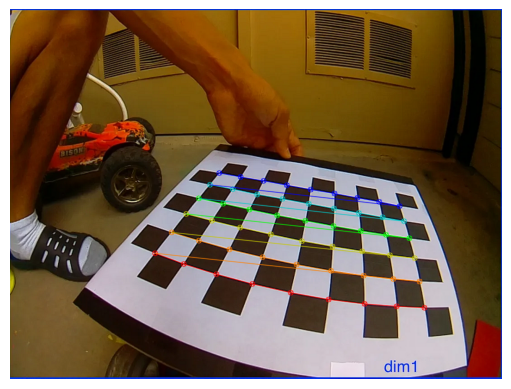

In [3]:
ret, mtx, dist, rvecs, tvecs = scanner_calibrate_camera(show_images=True)

# FUNCIÓN DE POSICIÓN

In [109]:
cv2 = cv
from cv2 import aruco
import pandas as pd
import matplotlib as mpl
from scipy.spatial.transform import Rotation
def get_camera_position(image, mtx, dist,show_images=False):
    # 1. Lectura de la imagen
    photo = cv2.imread(image)
    
    # 2. Aplicación de ArUco
    gray = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
    parameters =  aruco.DetectorParameters()
    detector = aruco.ArucoDetector(aruco_dict, parameters)
    corners, ids, rejectedImgPoints = detector.detectMarkers(gray)

    # 3. Lectura de ArUco
    if len(corners) < 4 :
        print("not all arucos detected")
        return [],[],[]
        
    corners2 = np.array([c[0] for c in corners])
    data = pd.DataFrame({"x": corners2[:,:,0].flatten(), "y": corners2[:,:,1].flatten()},
                       index = pd.MultiIndex.from_product( 
                               [ids.flatten(), ["c{0}".format(i )for i in np.arange(4)+1]], 
                           names = ["marker", ""] ))


    data = data.unstack().swaplevel(0, 1, axis = 1).stack()
    data["m1"] = data[["c1", "c2"]].mean(axis = 1)
    data["m2"] = data[["c2", "c3"]].mean(axis = 1)
    data["m3"] = data[["c3", "c4"]].mean(axis = 1)
    data["m4"] = data[["c4", "c1"]].mean(axis = 1)
    data["o"] = data[["m1", "m2", "m3", "m4"]].mean(axis = 1)
    
    # 4. Obtención de esquinas
    aruco1 = list(data.loc[(1, "c1")].values)
    aruco4 = list(data.loc[(4, "c2")].values)
    aruco12 = list(data.loc[(12, "c3")].values)
    aruco9 = list(data.loc[(9, "c4")].values)
    
    # 5. Estimación de la posición
    im = photo
    size = im.shape

    imageWidth = size[1]
    imageHeight = size[0]
    imageSize = [imageWidth, imageHeight]

    points_2D = np.array([
                                (aruco1),     (aruco4),
                                (aruco9),     (aruco12)     
                            ])

    width= 0.262
    height = 0.281

    points_3D = np.array([
                                (-width/2, -height/2., 0),  (width/2, -height/2., 0) ,
                                (-width/2, height/2., 0), (width/2, height/2., 0)
                            ])

    success, rvecs, tvecs = cv2.solvePnP(points_3D, points_2D, mtx, dist)

    np_rodrigues = np.asarray(rvecs[:,:],np.float64)
    rmat = cv2.Rodrigues(np_rodrigues)[0]
    camera_position = -np.matrix(rmat).T @ np.matrix(tvecs)
    #Test the solvePnP by projecting the 3D Points to camera
    projPoints = cv2.projectPoints(points_3D, rvecs, tvecs, mtx, dist)[0]
    
    if show_images:
        plt.axis("off")
        # Colors for each ArUco marker
        colors_2D = [(155, 0, 0), (0, 155, 0), (0, 0, 155), (155, 155, 0)]  # Red, Green, Blue, Yellow for 2D points
        colors_3D = [(255, 150, 150), (150, 255, 150), (150, 150, 255), (255, 255, 150)]   # Cyan, Magenta, Orange, Spring green for 3D points
    
        # Detected in original 2D image
        for p, color in zip(points_2D, colors_2D):
            im = cv2.circle(im, (int(p[0]), int(p[1])), 30, color, -1)
    
        # Estimation in 3D and projected in 2D again
        for p, color in zip(projPoints, colors_3D):
            im = cv2.circle(im, (int(p[0][0]), int(p[0][1])), 30, color, -1)

        plt.imshow(im)
        plt.show()
    
    # Compute rotation matrix
    rotation_matrix, _ = cv2.Rodrigues(rvecs)

    # Invert the transformation to get the camera position in world coordinates
    rotation_matrix_inv = rotation_matrix.T
    camera_position = -rotation_matrix_inv @ tvecs
    return camera_position, rotation_matrix, [aruco1, aruco4, aruco9, aruco12]


In [74]:
calibration_images = "img/v2/pid-alf/*.jpg"
# ret, mtx, dist, rvecs, tvecs = scanner_calibrate_camera(calibration_images,False)
ret, mtx, dist, rvecs, tvecs = calibrate_from_template("img/v2/pid-cube/*.jpg",False)

calibration done


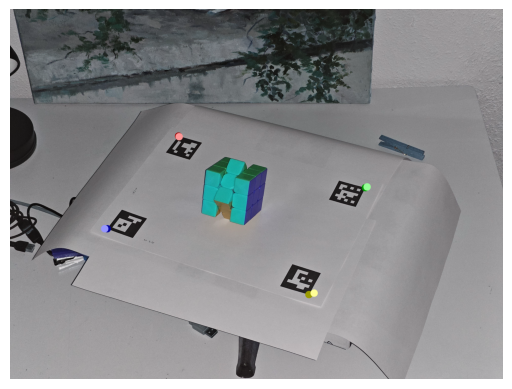

Posición: [[0.31256677]
 [3.57762644]
 [2.41782442]]
Rotación: [[ 0.92519679 -0.24469222 -0.29006313]
 [ 0.37848016  0.5393187   0.75225535]
 [-0.02763456 -0.80576737  0.59158708]]


In [80]:
image_name = "img/v2/pid-cube/20240509_235711.jpg"
position, rotation, arucos = get_camera_position(image_name, mtx, dist, show_images=True)

print("Posición:", position)
print("Rotación:", rotation)

In [7]:
!pip install plotly

In [110]:
image_names = glob.glob("img/v2/pid-alf/*.jpg")

import plotly.graph_objects as go
import plotly
# Assuming get_camera_position, mtx, and dist are already defined



# Prepare lists to hold x, y, z coordinates for the camera positions
positions = []
x_coords = []
y_coords = []
z_coords = []

# Iterate over each image name
i=0
colors=[]
for image_name in image_names:
    i=i+1
    if i >200 : continue;
    position, rotation, _ = get_camera_position(image_name, mtx, dist, show_images=False)
    positions.append(position)
    x_coords.append(position[0][0])
    y_coords.append(position[1][0])
    z_coords.append(position[2][0])
    colors.append(i)



# Configure the trace.
trace = go.Scatter3d(
    x=x_coords,  # <-- Put your data instead
    y=y_coords,  # <-- Put your data instead
    z=z_coords,  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 5,
        'opacity': 0.8,
        'color': colors,
    }
)

data = [trace]

plot_figure = go.Figure(data=data)

# Render the plot.
plotly.offline.iplot(plot_figure)

# Siluetas

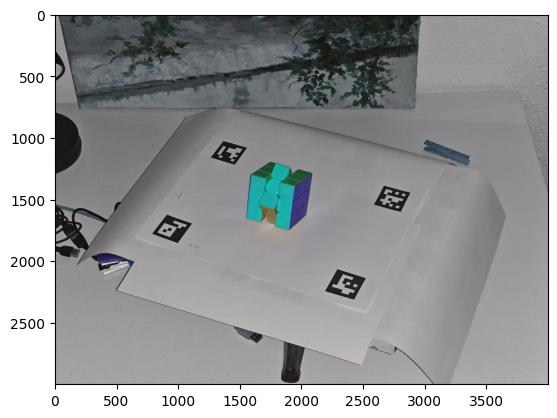

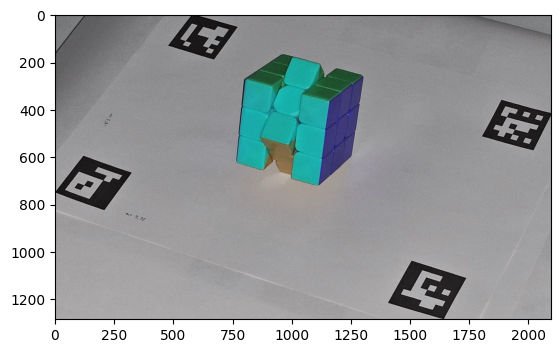

Borders(top=1030, bottom=685, left=788, right=1117)


In [12]:
import cv2 as cv
import numpy as np


from collections import namedtuple

def trim_image_by_points(image, points_in_image, margin=[0,0,0,0]):
    # Define a named tuple type for borders
    Borders = namedtuple('Borders', ['top', 'bottom', 'left', 'right'])
    
    # Convert points to a numpy array if it isn't already
    points = np.array(points_in_image)

    # Calculate the minimum and maximum x and y coordinates
    min_x = np.min(points[:, 0])
    max_x = np.max(points[:, 0])
    min_y = np.min(points[:, 1])
    max_y = np.max(points[:, 1])

    # Calculate borders
    top_border = int(min_y - margin[0])
    bottom_border = int(image.shape[0] - max_y - margin[1])
    left_border = int(min_x - margin[2])
    right_border = int(image.shape[1] - max_x - margin[3])

    # Trim the image using calculated coordinates
    trimmed_image = image[top_border:int(image.shape[0] - bottom_border),
                          left_border:int(image.shape[1] - right_border)]

    # Create a named tuple for borders
    borders = Borders(top=top_border, bottom=bottom_border, left=left_border, right=right_border)

    return trimmed_image, borders

# Example usage:

image = cv2.imread(image_name) #ejemplo anterior
plt.imshow(image)
plt.show()

result_image, borders = trim_image_by_points(image,arucos,[0,0,0,0])
plt.imshow(result_image)
plt.show()
print(borders)


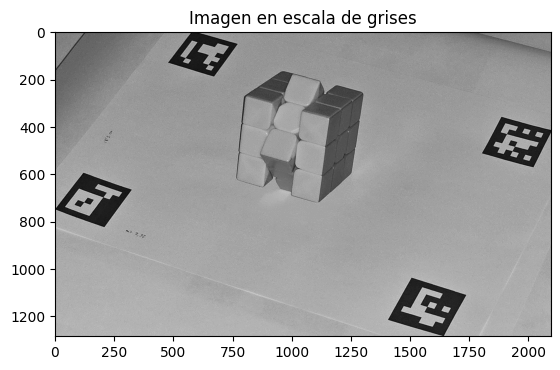

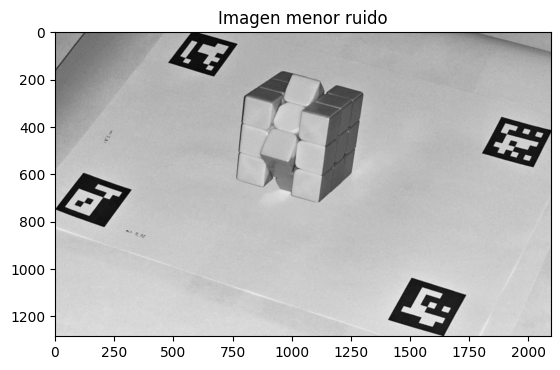

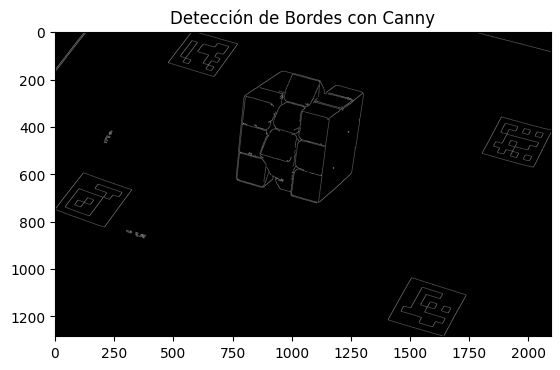

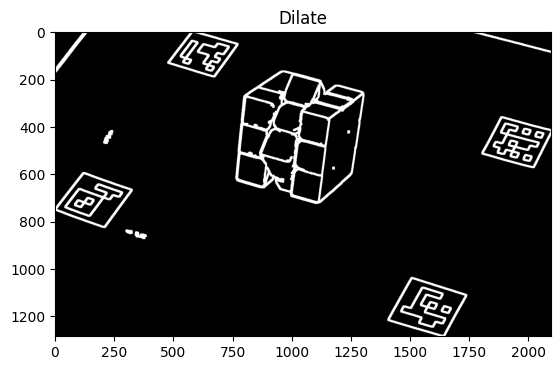

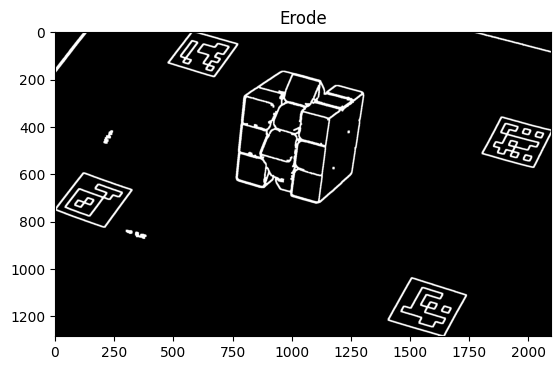

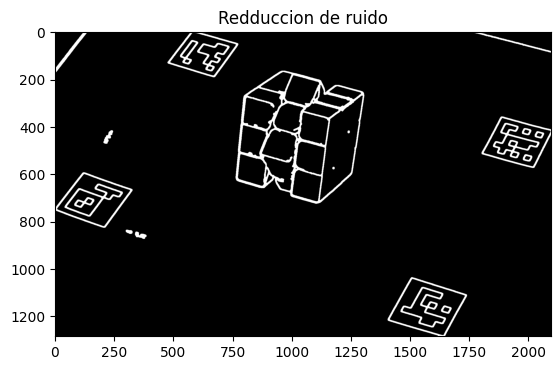

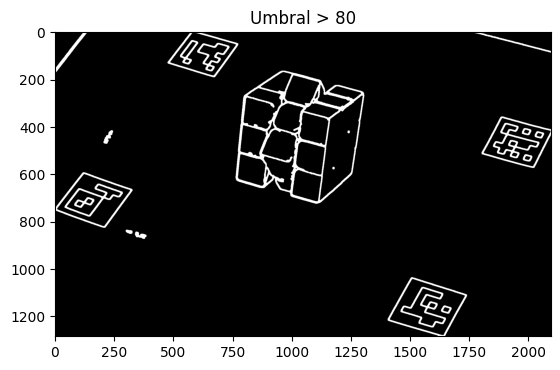

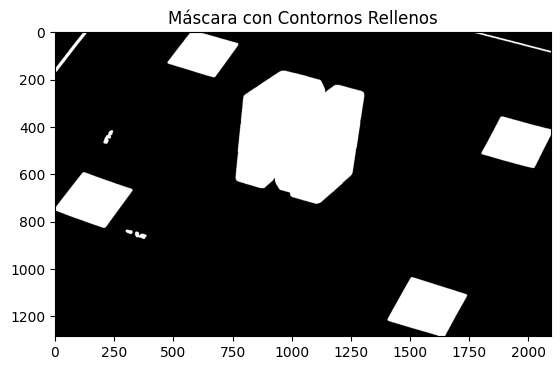

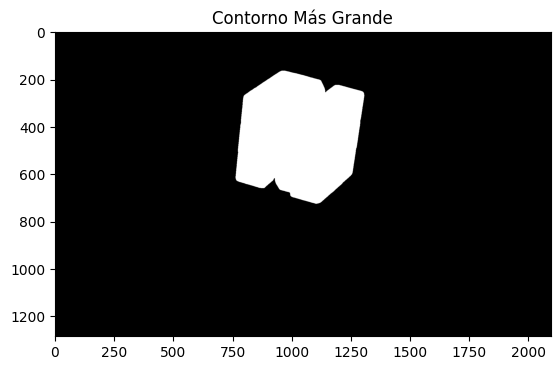

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_image(image,showImages=False):
    # Cargar la imagen

    if image is None:
        return "No se pudo cargar la imagen"
    
    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if showImages:
        plt.imshow(gray, cmap='gray')
        plt.title('Imagen en escala de grises')
        plt.show()
    # Reduccion de ruido
    gray = cv2.GaussianBlur(gray, (7,7), 0)
    if showImages:
        plt.imshow(gray, cmap='gray')
        plt.title('Imagen menor ruido')
        plt.show()

    # Detección de bordes con Canny
    t_lower = 5  # Lower Threshold 
    t_upper = 120  # Upper threshold 
    edges = cv2.Canny(gray, t_lower, t_upper)
    if showImages:
        plt.imshow(edges, cmap='gray')
        plt.title('Detección de Bordes con Canny')
        plt.show()


    # Engrosar los bordes detectados
        # Crear un kernel
    kernel = np.ones((8,8), np.uint8)
    
    # Aplicar la operación de apertura
    dilated_image = cv2.morphologyEx(edges, cv2.MORPH_DILATE, kernel)
    if showImages:
        plt.imshow(dilated_image, cmap='gray')
        plt.title('Dilate')
        plt.show()
    kernel = np.ones((3,3), np.uint8)
    erode_image = cv2.morphologyEx(dilated_image, cv2.MORPH_ERODE, kernel)
    if showImages:
        plt.imshow(erode_image, cmap='gray')
        plt.title('Erode')
        plt.show()
    
    # Aplicar filtro  para eliminar el ruido
    blurred_image = cv2.medianBlur(erode_image, 5)
    if showImages:
        plt.imshow(blurred_image, cmap='gray')
        plt.title('Redduccion de ruido')
        plt.show()

        # Aplicar umbral para mantener solo los valores de gris > 200
    thesh=80
    _, thresholded_image = cv2.threshold(blurred_image, thesh, 255, cv2.THRESH_BINARY)
    
    # Mostrar la imagen umbralizada
    if showImages:
        plt.imshow(thresholded_image, cmap='gray')
        plt.title('Umbral > '+str(thesh))
        plt.show()

    # Encontrar contornos
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Dibujar y rellenar contornos
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    if showImages:

        plt.imshow(mask, cmap='gray')
        plt.title('Máscara con Contornos Rellenos')
        plt.show()

    # Encontrar el contorno más grande basado en el área
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Crear una imagen para mostrar el contorno más grande
    largest_contour_image = np.zeros_like(gray)
    cv2.drawContours(largest_contour_image, [largest_contour], -1, (255), thickness=cv2.FILLED)
    
    # Mostrar el contorno más grande
    if showImages:
        plt.imshow(largest_contour_image, cmap='gray')
        plt.title('Contorno Más Grande')
        plt.show()

    return largest_contour_image
    

# Llamada a la función
silhouette = process_image(result_image,showImages=True)


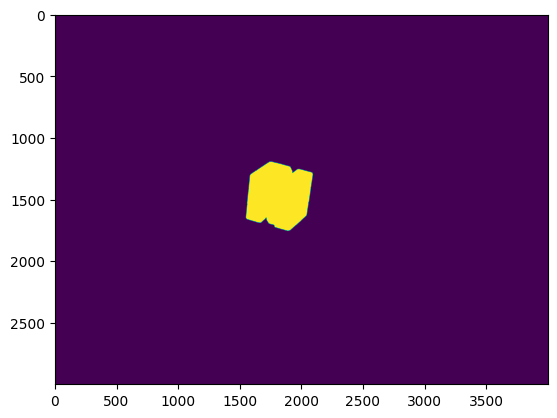

In [14]:
new_image = cv2.copyMakeBorder(silhouette, borders.top, borders.bottom, borders.left, borders.right, 
                                   cv2.BORDER_CONSTANT, value=[0, 0, 0])
plt.imshow(new_image)
plt.show()

# Algoritmo principal de preparacion de imagenes

Recorre las imagenes genera las siluetas y detecta los parametros de la camara para pasarselos al visual hull

loading images:  ['img/v2/pid-chess\\20240509_235220.jpg', 'img/v2/pid-chess\\20240509_235230.jpg', 'img/v2/pid-chess\\20240509_235237.jpg', 'img/v2/pid-chess\\20240509_235247.jpg', 'img/v2/pid-chess\\20240509_235255.jpg', 'img/v2/pid-chess\\20240509_235303.jpg', 'img/v2/pid-chess\\20240509_235311.jpg', 'img/v2/pid-chess\\20240509_235319.jpg', 'img/v2/pid-chess\\20240509_235328.jpg', 'img/v2/pid-chess\\20240509_235335.jpg']
Loading image: img/v2/pid-chess\20240509_235220.jpg
img/v2/pid-chess\20240509_235220.jpg: calibrate success
Loading image: img/v2/pid-chess\20240509_235230.jpg
img/v2/pid-chess\20240509_235230.jpg: calibrate success
Loading image: img/v2/pid-chess\20240509_235237.jpg
img/v2/pid-chess\20240509_235237.jpg: calibrate success
Loading image: img/v2/pid-chess\20240509_235247.jpg
img/v2/pid-chess\20240509_235247.jpg: calibrate success
Loading image: img/v2/pid-chess\20240509_235255.jpg
img/v2/pid-chess\20240509_235255.jpg: calibrate success
Loading image: img/v2/pid-chess\

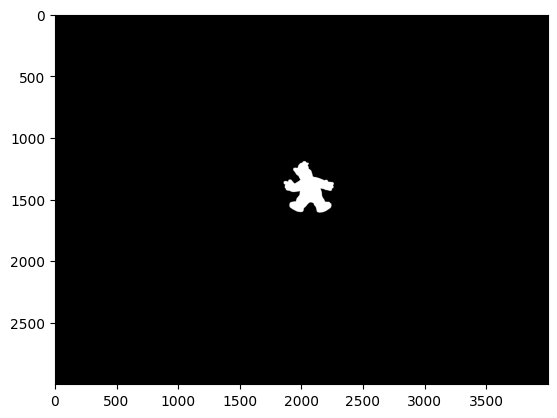

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.99967074 -0.01902995 -0.01721279]
 [ 0.00497308  0.51440482 -0.85753306]
 [ 0.02517315 -0.85733631 -0.5141408 ]] t [[ 0.13754784]
 [-0.07046259]
 [ 1.06161914]]
img/v2/pid-alf\20240509_235922.jpg


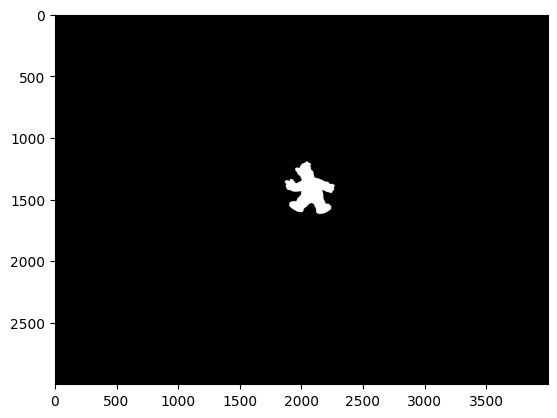

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.99626018 -0.08224549  0.02648271]
 [-0.06507895  0.51264754 -0.85612921]
 [ 0.05683647 -0.85465091 -0.51608278]] t [[ 0.14842547]
 [-0.0599178 ]
 [ 1.0580619 ]]
img/v2/pid-alf\20240509_235932.jpg


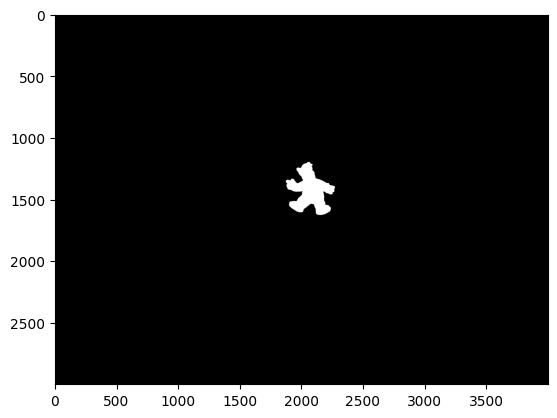

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.99033478 -0.12709491  0.05553293]
 [-0.11324789  0.50981601 -0.8527969 ]
 [ 0.08007457 -0.85084342 -0.51928176]] t [[ 0.15551303]
 [-0.05223723]
 [ 1.0570355 ]]
img/v2/pid-alf\20240509_235940.jpg


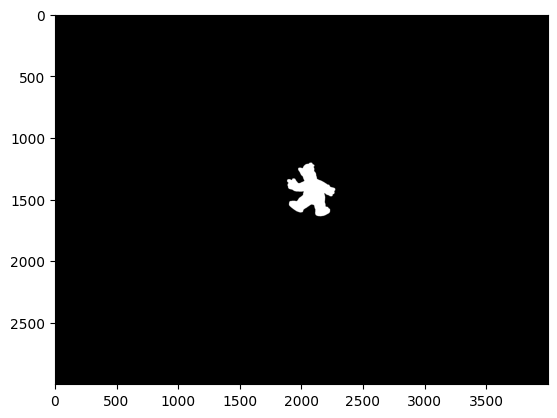

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.97835399 -0.18411714  0.09446875]
 [-0.17654877  0.50448485 -0.84517783]
 [ 0.10795367 -0.84356145 -0.52607042]] t [[ 0.16398144]
 [-0.04188762]
 [ 1.05663103]]
img/v2/pid-alf\20240509_235947.jpg


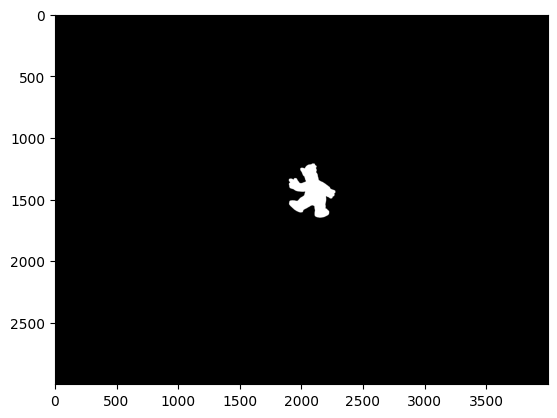

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.9580743  -0.25081018  0.13852037]
 [-0.2498441   0.49465473 -0.83240292]
 [ 0.14025537 -0.83211234 -0.53657942]] t [[ 0.17295186]
 [-0.02924978]
 [ 1.05791953]]
img/v2/pid-alf\20240510_000001.jpg


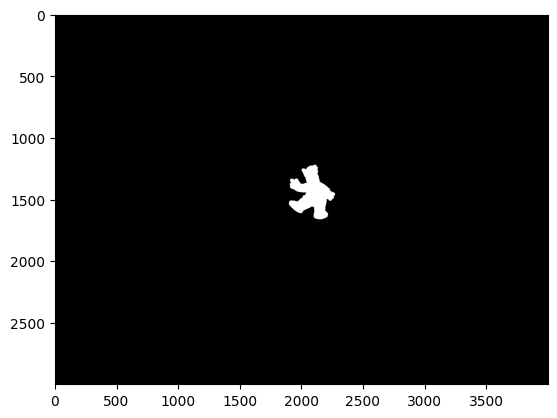

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.93703293 -0.30275711  0.17409025]
 [-0.30830809  0.48294017 -0.81958216]
 [ 0.16405915 -0.82164891 -0.54587331]] t [[ 0.17885699]
 [-0.01763444]
 [ 1.05987263]]
img/v2/pid-alf\20240510_000009.jpg


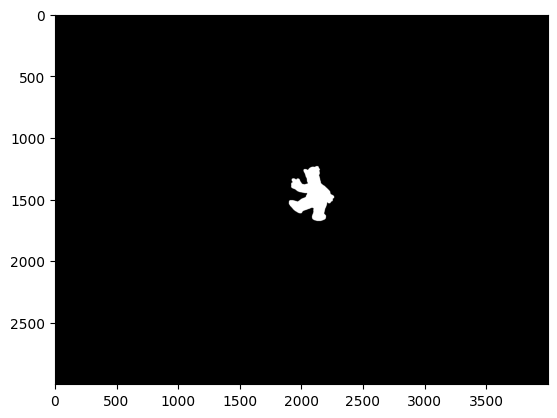

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.8992053  -0.37685363  0.22228623]
 [-0.39107604  0.46447195 -0.79455984]
 [ 0.19618704 -0.80140324 -0.56503406]] t [[ 0.18593302]
 [-0.00152574]
 [ 1.06596801]]
img/v2/pid-alf\20240510_000016.jpg


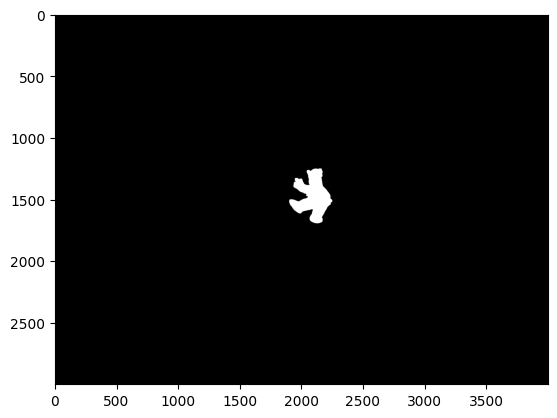

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.82233298 -0.48820883  0.29226805]
 [-0.51655598  0.4251233  -0.74326314]
 [ 0.23861767 -0.7621826  -0.6017801 ]] t [[0.19373568]
 [0.02481823]
 [1.08076056]]
img/v2/pid-alf\20240510_000024.jpg


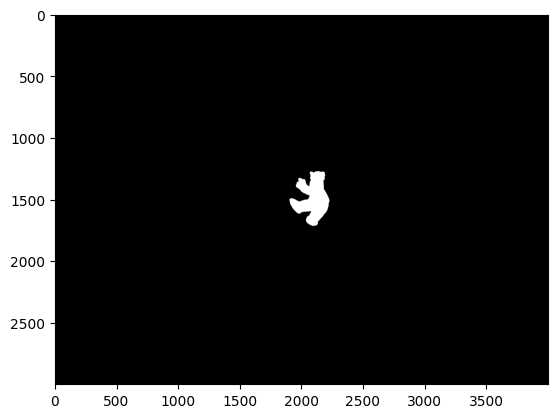

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.69746456 -0.61650306  0.36533157]
 [-0.66288409  0.36134476 -0.65575502]
 [ 0.27226433 -0.69953837 -0.66069524]] t [[0.19659242]
 [0.0591904 ]
 [1.10711398]]
img/v2/pid-alf\20240510_000032.jpg


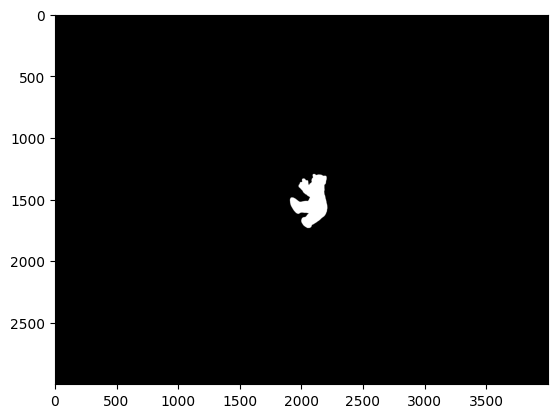

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.51246802 -0.74801224  0.42172766]
 [-0.81295577  0.26445622 -0.51881193]
 [ 0.27654917 -0.60872046 -0.74362622]] t [[0.19015809]
 [0.10059527]
 [1.14882598]]
img/v2/pid-alf\20240510_000040.jpg


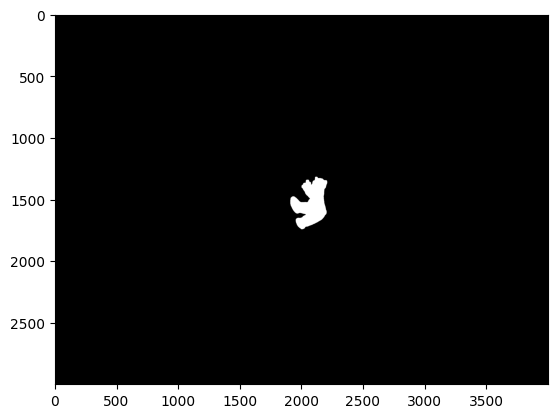

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.26113398 -0.85708265  0.44409275]
 [-0.94291346  0.1279709  -0.30746978]
 [ 0.20669606 -0.49903183 -0.84157232]] t [[0.16983987]
 [0.14614314]
 [1.20151318]]
img/v2/pid-alf\20240510_000047.jpg


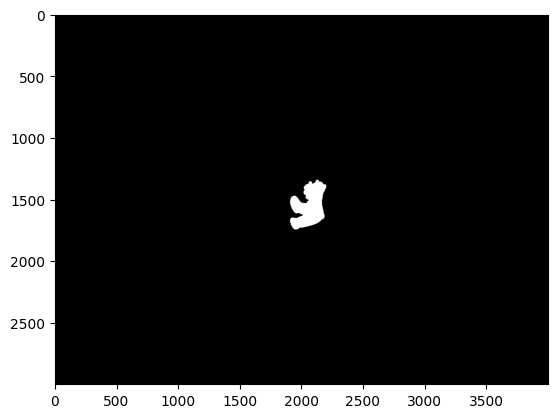

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.00785273 -0.88514921  0.46524102]
 [-0.99888414 -0.02861132 -0.03757477]
 [ 0.04657044 -0.46442681 -0.88438619]] t [[0.13396325]
 [0.1835531 ]
 [1.2364253 ]]
img/v2/pid-alf\20240510_000054.jpg


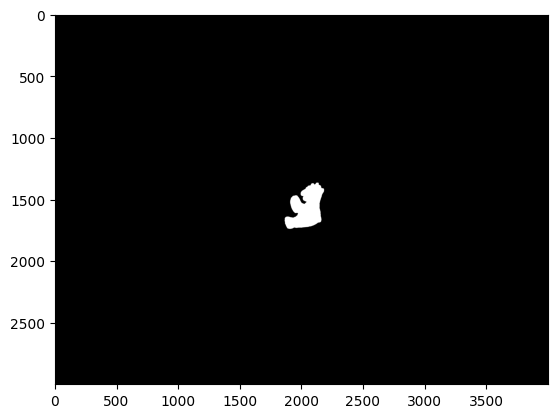

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.27747973 -0.83227866 -0.47991378]
 [-0.92712325 -0.10100251 -0.36088914]
 [ 0.25188783  0.54507864 -0.79965104]] t [[0.07119484]
 [0.17988991]
 [1.01946724]]
img/v2/pid-alf\20240510_000101.jpg


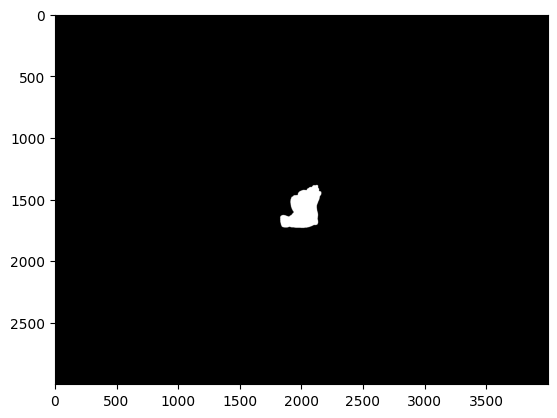

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.46597645 -0.75013537 -0.46921517]
 [-0.83723937 -0.20230217 -0.50803944]
 [ 0.28617511  0.62957983 -0.72231091]] t [[0.03082725]
 [0.17928412]
 [0.95350798]]
img/v2/pid-alf\20240510_000108.jpg


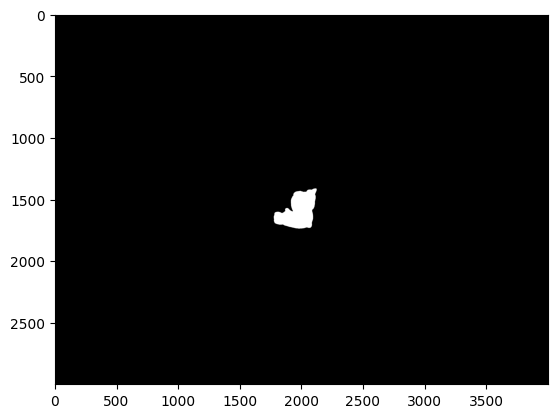

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.69372157 -0.59743933 -0.40226438]
 [-0.66777427 -0.32425183 -0.67002856]
 [ 0.26986646  0.73343507 -0.6238951 ]] t [[-0.02549459]
 [ 0.16935136]
 [ 0.87486487]]
img/v2/pid-alf\20240510_000115.jpg


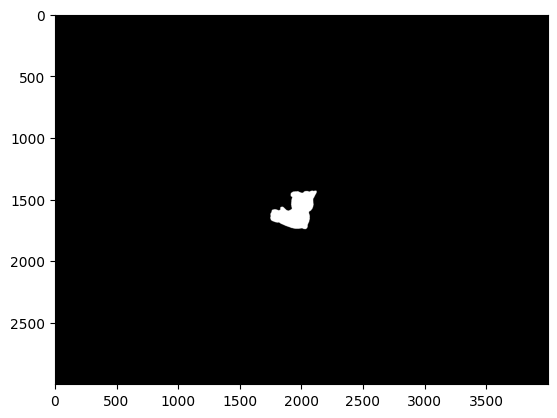

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.80101248 -0.49339092 -0.33903452]
 [-0.54945995 -0.38111934 -0.74353333]
 [ 0.23763998  0.78186537 -0.5763799 ]] t [[-0.05639774]
 [ 0.15881617]
 [ 0.84041832]]
img/v2/pid-alf\20240510_000123.jpg


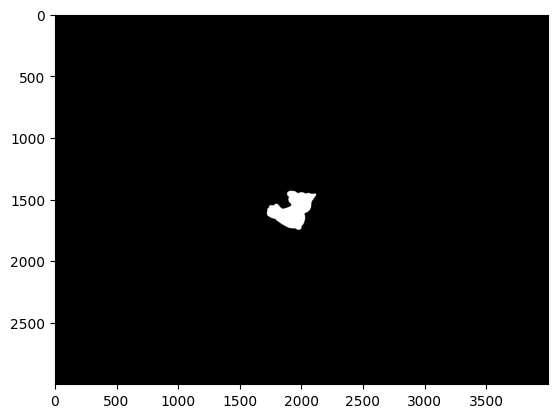

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.90994851 -0.34229375 -0.2341553 ]
 [-0.37602558 -0.4428135  -0.81395391]
 [ 0.17492421  0.82870452 -0.53164869]] t [[-0.09357322]
 [ 0.14074418]
 [ 0.81138378]]
img/v2/pid-alf\20240510_000132.jpg


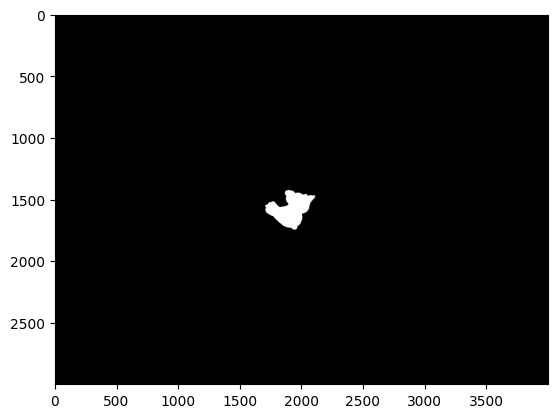

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.95699162 -0.2417437  -0.16039646]
 [-0.26032127 -0.47148826 -0.84257442]
 [ 0.12806201  0.84809127 -0.51414134]] t [[-0.11454479]
 [ 0.1272787 ]
 [ 0.80449207]]
img/v2/pid-alf\20240510_000140.jpg


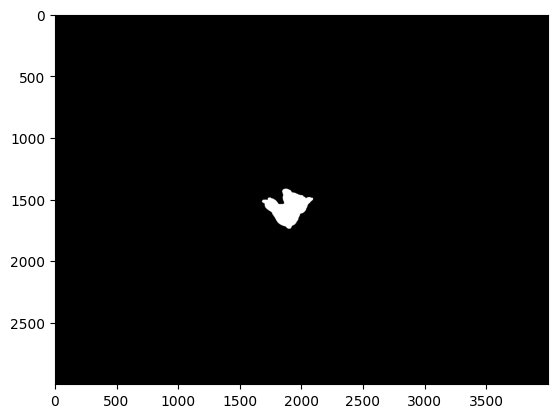

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.9937399  -0.09740825 -0.05470512]
 [-0.09627529 -0.49826662 -0.86166202]
 [ 0.05667525  0.86153468 -0.50452543]] t [[-0.13984655]
 [ 0.10681195]
 [ 0.8081435 ]]
img/v2/pid-alf\20240510_000152.jpg


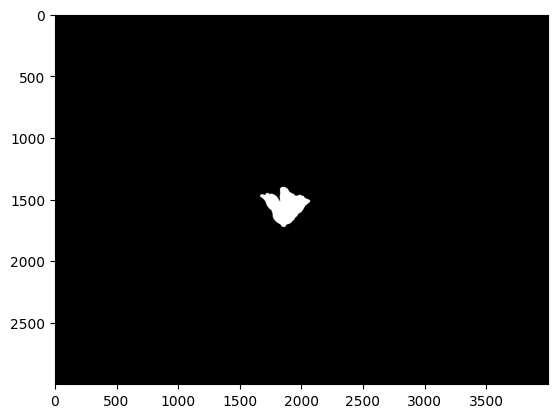

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.99680463  0.05759179  0.05535082]
 [ 0.07700326 -0.50859114 -0.8575579 ]
 [-0.02123736  0.85907988 -0.51140076]] t [[-0.16219676]
 [ 0.08378267]
 [ 0.82977221]]
img/v2/pid-alf\20240510_000200.jpg


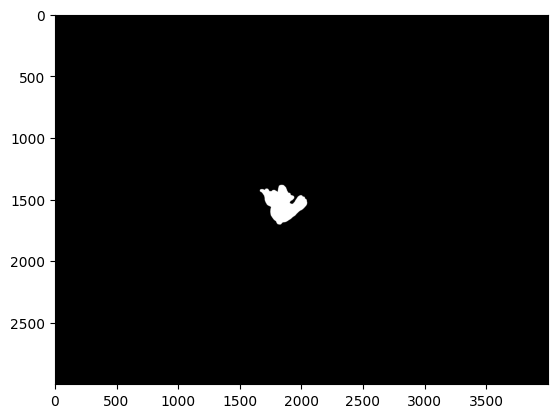

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.96461128  0.21096564  0.15817259]
 [ 0.24566078 -0.50112096 -0.82977622]
 [-0.09579068  0.8392683  -0.53521291]] t [[-0.17955135]
 [ 0.05963798]
 [ 0.86351727]]
img/v2/pid-alf\20240510_000208.jpg


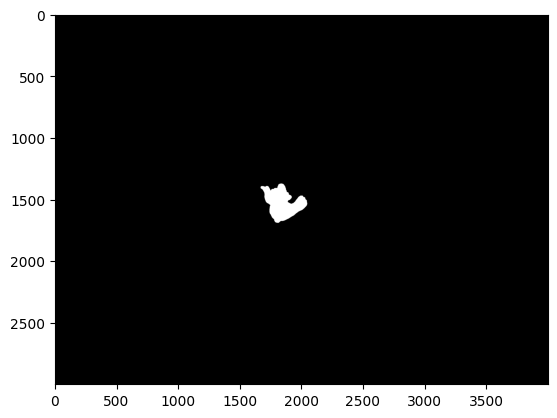

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.92965798  0.29916363  0.21502828]
 [ 0.34257316 -0.48715623 -0.80331964]
 [-0.13557165  0.82047543 -0.55537411]] t [[-0.18745712]
 [ 0.04463565]
 [ 0.88828795]]
img/v2/pid-alf\20240510_000216.jpg


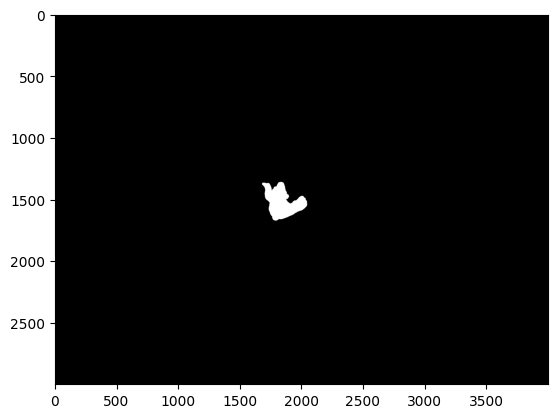

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.8733184   0.40181654  0.27542409]
 [ 0.45314045 -0.46250886 -0.76206908]
 [-0.17882588  0.79033475 -0.58599683]] t [[-0.19475401]
 [ 0.02641417]
 [ 0.92328972]]
img/v2/pid-alf\20240510_000224.jpg


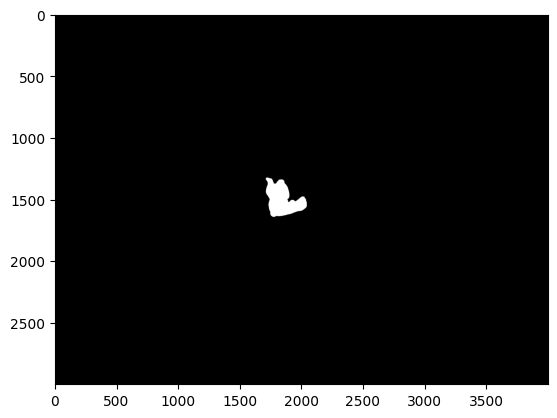

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.74826115  0.55828084  0.35836818]
 [ 0.62206712 -0.40275037 -0.67143476]
 [-0.23051624  0.72533761 -0.64865061]] t [[-0.20100689]
 [-0.00441043]
 [ 0.986287  ]]
img/v2/pid-alf\20240510_000232.jpg


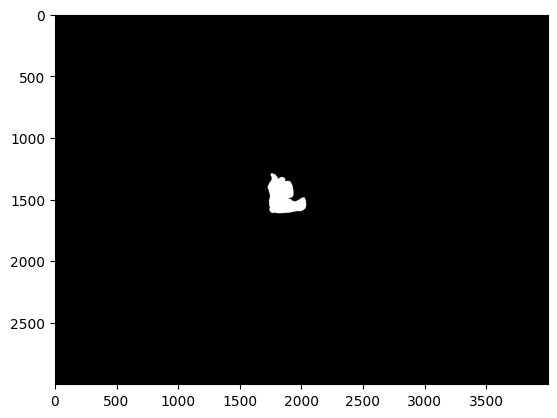

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.57998378  0.70007699  0.41654654]
 [ 0.77537014 -0.31758619 -0.54583895]
 [-0.24983986  0.63955548 -0.72701364]] t [[-0.19995305]
 [-0.03632075]
 [ 1.058754  ]]
img/v2/pid-alf\20240510_000239.jpg


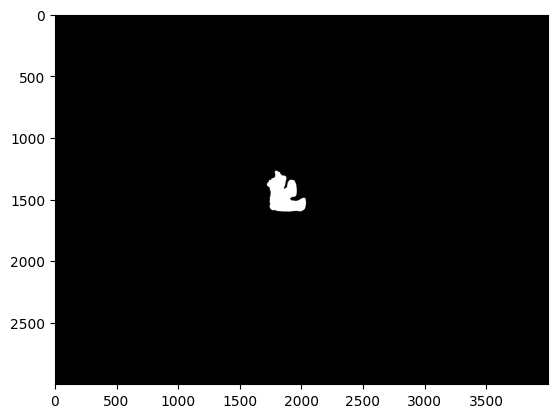

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.43400108  0.78694171  0.43859526]
 [ 0.87062879 -0.24119074 -0.42875698]
 [-0.23162163  0.56793465 -0.78981115]] t [[-0.1934387 ]
 [-0.05943153]
 [ 1.10864589]]
img/v2/pid-alf\20240510_000246.jpg


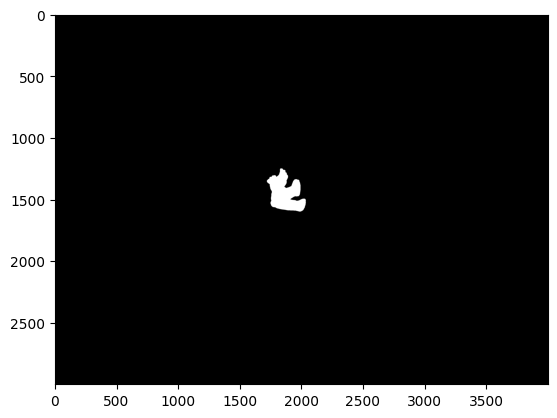

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.24115598  0.86293878  0.44405005]
 [ 0.95707107 -0.13565206 -0.25615128]
 [-0.16080657  0.48675987 -0.85860705]] t [[-0.17918662]
 [-0.08482791]
 [ 1.15766411]]
img/v2/pid-alf\20240510_000254.jpg


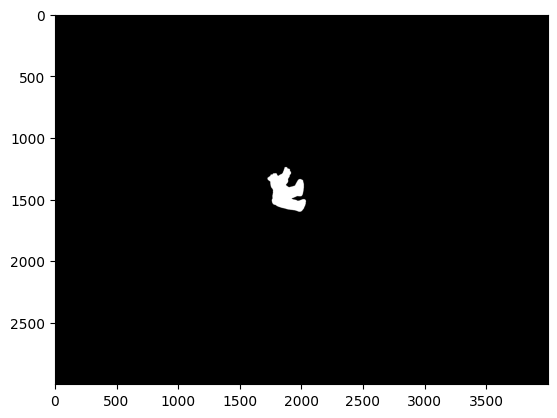

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.0475995   0.90949857 -0.41297292]
 [ 0.99411415 -0.08341675 -0.0691282 ]
 [-0.09732086 -0.40725175 -0.908116  ]] t [[-0.17257637]
 [-0.09621408]
 [ 1.28800126]]
img/v2/pid-alf\20240510_000302.jpg


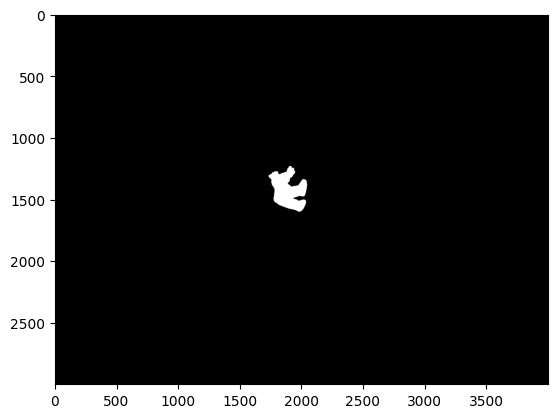

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.10102912  0.89496176 -0.43455329]
 [ 0.97714104  0.00713909 -0.21247217]
 [-0.18705215 -0.44608573 -0.87522512]] t [[-0.14913414]
 [-0.11088088]
 [ 1.28612645]]
img/v2/pid-alf\20240510_000310.jpg


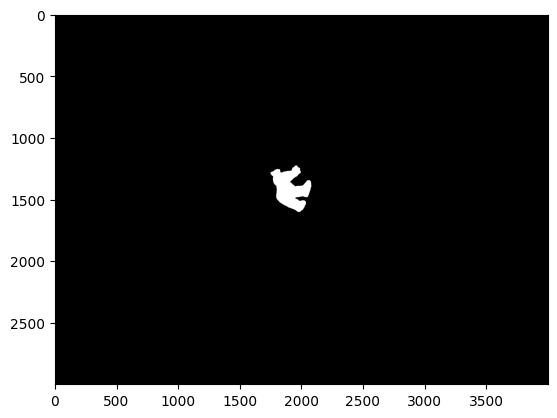

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.30177241  0.83527996 -0.45960941]
 [ 0.91775541  0.1239587  -0.37730524]
 [-0.25818292 -0.53566933 -0.80399001]] t [[-0.11127147]
 [-0.12438853]
 [ 1.26218206]]
img/v2/pid-alf\20240510_000318.jpg


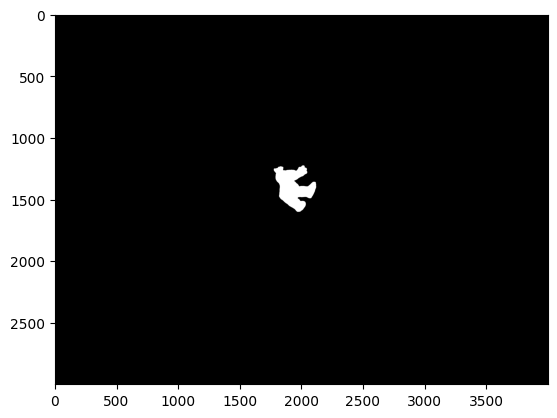

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.50214881  0.7379021  -0.4509402 ]
 [ 0.81798609  0.23608161 -0.52456098]
 [-0.28061596 -0.63227048 -0.72214176]] t [[-0.06644828]
 [-0.13184594]
 [ 1.22418569]]
img/v2/pid-alf\20240510_000326.jpg


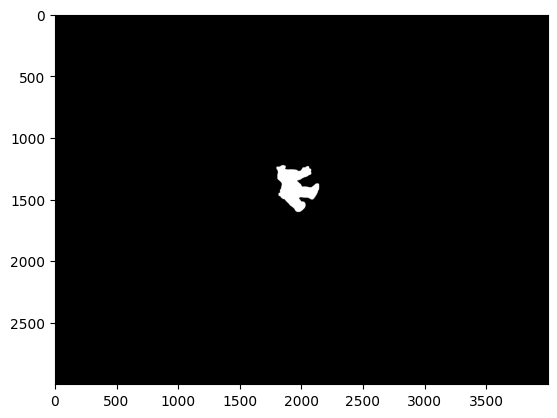

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.61631268  0.66265042 -0.42550335]
 [ 0.73846011  0.29861081 -0.60457279]
 [-0.27356051 -0.68682312 -0.67337853]] t [[-0.0373486 ]
 [-0.13257567]
 [ 1.19733971]]
img/v2/pid-alf\20240510_000333.jpg


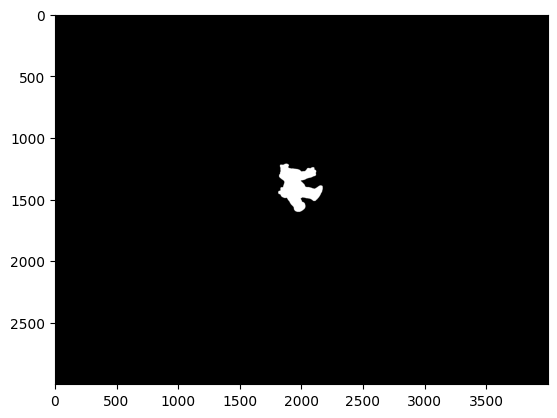

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.72940673  0.56758536 -0.38185426]
 [ 0.63733608  0.36103962 -0.68077391]
 [-0.24853279 -0.73993057 -0.62508735]] t [[-0.00477904]
 [-0.13045135]
 [ 1.16657904]]
img/v2/pid-alf\20240510_000341.jpg


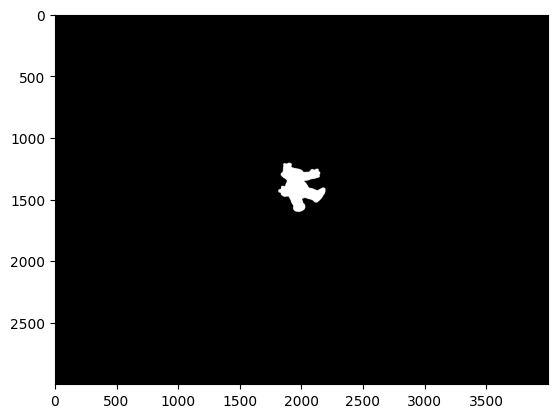

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.81141839  0.47836339 -0.33581047]
 [ 0.54319088  0.40513219 -0.73539892]
 [-0.21574029 -0.77912539 -0.58857434]] t [[ 0.02259733]
 [-0.12589107]
 [ 1.14028324]]
img/v2/pid-alf\20240510_000348.jpg


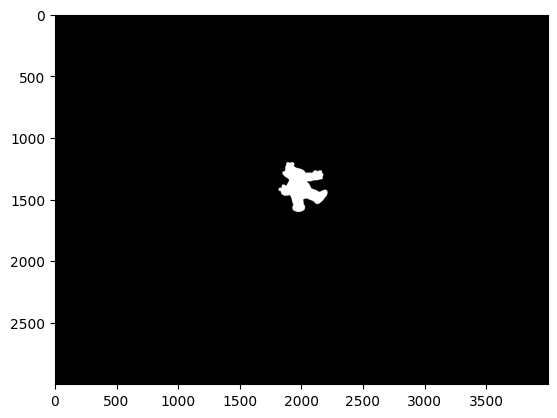

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.87036729  0.39910351 -0.28840451]
 [ 0.45756023  0.4391268  -0.77317934]
 [-0.18193243 -0.80491244 -0.5648155 ]] t [[ 0.04470131]
 [-0.12033502]
 [ 1.12081757]]
img/v2/pid-alf\20240510_000356.jpg


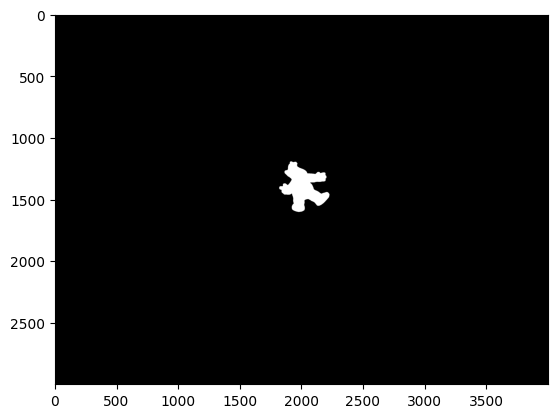

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.91993592  0.31352805 -0.23541042]
 [ 0.36513068  0.46638556 -0.8057072 ]
 [-0.14281978 -0.82715457 -0.54352353]] t [[ 0.06702189]
 [-0.11245784]
 [ 1.10354508]]
img/v2/pid-alf\20240510_000403.jpg


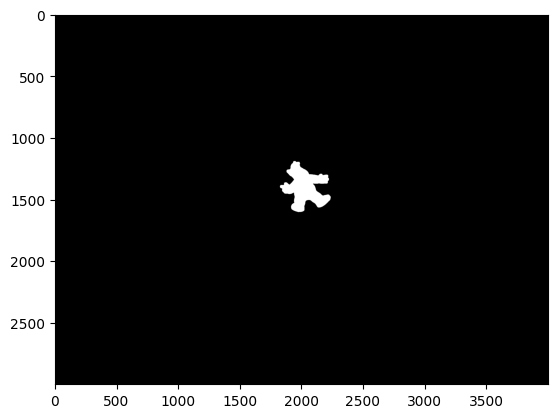

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.95542154  0.23149924 -0.18324242]
 [ 0.27692015  0.48739142 -0.82810919]
 [-0.10239587 -0.84193688 -0.52977107]] t [[ 0.08672673]
 [-0.10389101]
 [ 1.08873484]]
img/v2/pid-alf\20240510_000411.jpg


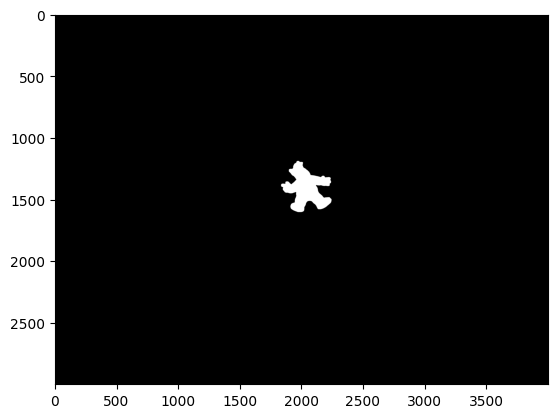

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.98090331  0.1462229  -0.12824803]
 [ 0.18525032  0.50150735 -0.84508739]
 [-0.0592538  -0.85270701 -0.51901806]] t [[ 0.10557196]
 [-0.09366661]
 [ 1.07622581]]
img/v2/pid-alf\20240510_000418.jpg


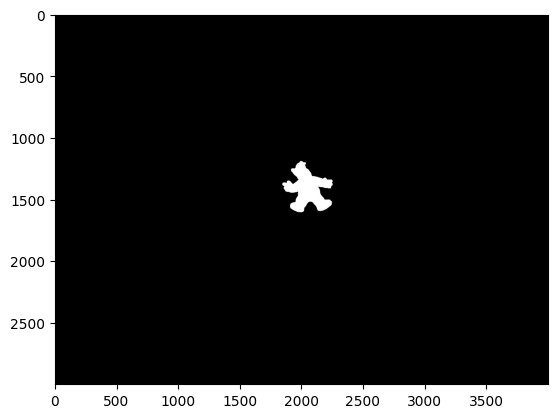

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.99495475  0.06789667 -0.0738586 ]
 [ 0.0982354   0.50986836 -0.8546251 ]
 [-0.02036803 -0.85756883 -0.5139658 ]] t [[ 0.1217834 ]
 [-0.08270507]
 [ 1.06674683]]
img/v2/pid-alf\20240510_000424.jpg


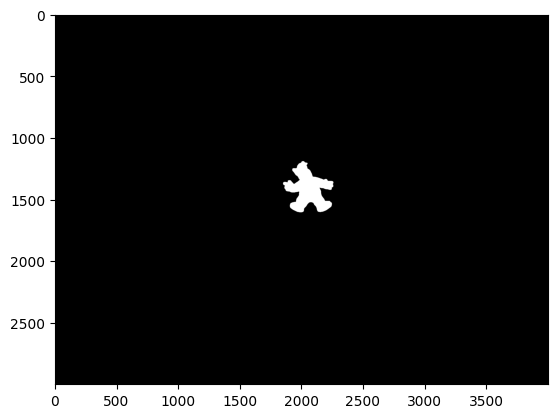

k [[6.05421057e+03 0.00000000e+00 2.04628975e+03]
 [0.00000000e+00 5.61897367e+03 1.47962449e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.99869678  0.02284496 -0.04563816]
 [ 0.05089396  0.51259526 -0.85712071]
 [ 0.00381301 -0.8583264  -0.5130899 ]] t [[ 0.13029833]
 [-0.07634011]
 [ 1.06387597]]


In [18]:
import glob
calibration_image_path = "img/v2/pid-chess/*.jpg"
images_paths = glob.glob("img/v2/pid-alf/*.jpg")
#1 Parametros de camara
ret, mtx, dist, rvecs, tvecs = scanner_calibrate_camera(calibration_image_path,show_images=False)
#Numero de imagenes exitosas
N=0
#Array de matrices
M=[]
#Imagenes en formato silueta
silhouettes = []
for file_name in images_paths:
    
    #1 Deteccion de arucos
    print(file_name)
    position, rotation , arucos = get_camera_position(file_name, mtx, dist)
    if len(arucos)<4 : 
        print("No se detectaron todos los marcadores, saltando imagen" )
        continue

    #2 Obtener siluetas
    image = cv.imread(file_name)
    # plt.imshow(image)
    # plt.show()
    # recorte de imagen por arucos
    result_image, borders = trim_image_by_points(image,arucos,[0,0,0,0])
    # obtencion de la silueta
    silhouette_short = process_image(result_image,showImages=False)
    silhouette_full = cv2.copyMakeBorder(silhouette_short, borders.top, borders.bottom, borders.left, borders.right, 
                                   cv2.BORDER_CONSTANT, value=[0, 0, 0])
    plt.imshow(silhouette_full,cmap="gray")
    plt.show()
    silhouettes.append(silhouette_full)
    K= mtx #parametros de la camara
    R= rotation
    t= position
    print("k",K,"R",R,"t",t)
    M.append(np.matmul(K, np.concatenate([R, t], axis=1)))
    N+=1
    
    
    
    

In [11]:
silhouettes = np.array(silhouettes).transpose(1, 2, 0)

# Visual Hull by egrigokhan

In [12]:
# Define a voxel grid which has the 3D locations of each voxel which can then be projected onto each image
def InitializeVoxels(xlim, ylim, zlim, voxel_size):
  voxels_number = [1, 1, 1]
  voxels_number[0] = np.abs(xlim[1]-xlim[0]) / voxel_size[0]
  voxels_number[1] = np.abs(ylim[1]-ylim[0]) / voxel_size[1]
  voxels_number[2] = np.abs(zlim[1]-zlim[0]) / voxel_size[2]
  voxels_number_act = np.array(voxels_number).astype(int) + 1
  total_number = np.prod(voxels_number_act)

  voxel = np.ones((int(total_number), 4))

  sx = xlim[0]
  ex = xlim[1]
  sy = ylim[0]
  ey = ylim[1]
  sz = zlim[0]
  ez = zlim[1]

  if(ex > sx):
    x_step = voxel_size[0];
  else:
    x_step = -voxel_size[0];

  if(ey > sy):
    y_step = voxel_size[1];
  else:
    y_step = -voxel_size[1];

  if(sz > ez):
    z_step = voxel_size[2];
  else:
    z_step = -voxel_size[2];

  voxel3Dx, voxel3Dy, voxel3Dz = np.meshgrid(np.linspace(sx, ex, voxels_number_act[0]), 
                                             np.linspace(sy, ey, voxels_number_act[1]),
                                             np.linspace(ez, sz, voxels_number_act[2]))
  
  l = 0;
  for z in np.linspace(ez, sz, voxels_number_act[2]):
    for x in np.linspace(sx, ex, voxels_number_act[0]):
      for y in np.linspace(sy, ey, voxels_number_act[1]):
        voxel[l] = [x, y, z, 1] 
        l=l+1

  return voxel, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number

In [13]:
voxel_size = [0.01, 0.01, 0.01] # size of each voxel
a=0.14
# The dimension limits
xlim = [-a, a]
ylim = [-a, a]
zlim = [-a, a]

voxels, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number = InitializeVoxels(xlim, ylim, zlim, voxel_size);

In [14]:
print(voxels.shape)

(24389, 4)


In [15]:
print(voxels.shape)

(24389, 4)


In [16]:
object_points3D = np.copy(voxels).T
voxels[:, 3] = 0 # making the fourth variable of each voxel 0

proj = []

for i in range(N):

  # CAMERA PARAMETERS
  M_ = M[i]

  # PROJECTION TO THE IMAGE PLANE
  points2D = np.matmul(M_, object_points3D)
  points2D = np.floor(points2D / points2D[2, :]).astype(np.int32)
  points2D[np.where(points2D < 0)] = 0; # check for negative image coordinates

  img_size = (silhouettes).shape
  ind1 = np.where(points2D[1, :] >= img_size[0]) # check for out-of-bounds (width) coordinate
  points2D[:, ind1] = 0
  ind1 = np.where(points2D[0, :] >= img_size[1]) # check for out-of-bounds (height) coordinate
  points2D[:, ind1] = 0

  # ACCUMULATE THE VALUE OF EACH VOXEL IN THE CURRENT IMAGE
  voxels[:, 3] += silhouettes[:, :, i].T[points2D.T[:, 0], points2D.T[:, 1]]

  proj.append(points2D)

In [17]:
print(voxels) # the fourth value is the number of image views (out of N total) which contain this voxel in the object mask

[[-1.40e-01 -1.40e-01  1.40e-01  0.00e+00]
 [-1.40e-01 -1.30e-01  1.40e-01  0.00e+00]
 [-1.40e-01 -1.20e-01  1.40e-01  0.00e+00]
 ...
 [ 1.40e-01  1.20e-01 -1.40e-01  1.02e+03]
 [ 1.40e-01  1.30e-01 -1.40e-01  7.65e+02]
 [ 1.40e-01  1.40e-01 -1.40e-01  7.65e+02]]


In [18]:
def ConvertVoxelList2Voxel3D(voxels_number, voxel_size, voxel):
  sx = -(voxels_number[0] / 2) * voxel_size[0]
  ex = voxels_number[0] / 2 * voxel_size[0]

  sy = -(voxels_number[1] / 2) * voxel_size[1]
  ey = voxels_number[1] / 2 * voxel_size[1]
  sz = 0;
  ez = voxels_number[2] * voxel_size[2]
  voxels_number = np.array(voxels_number).astype(np.int32)
  voxel3D = np.zeros((voxels_number[1] + 1, voxels_number[0] + 1, voxels_number[2] + 1));

  l = 0
  z1 = 0
  for z in np.arange(ez, sz, -voxel_size[2]):
      x1 = 0
      for x in np.arange(sx, ex, voxel_size[0]):
          y1 = 0
          for y in np.arange(sy, ey, voxel_size[1]):
              voxel3D[y1, x1, z1] = voxel[l, 3]
              l = l + 1
              y1 = y1 + 1
          x1 = x1 + 1
      z1 = z1 + 1

  return voxel3D

In [19]:
error_amount = 5
maxv = np.max(voxels[:, 3])
iso_value = maxv-np.round(((maxv)/100)*error_amount)-0.5
print('max number of votes:' + str(maxv))
print('threshold for marching cube:' + str(iso_value))

voxel3D = ConvertVoxelList2Voxel3D(np.array(voxels_number), voxel_size, voxels)

max number of votes:1275.0
threshold for marching cube:1210.5


In [20]:
!pip install --upgrade PyMCubes
!pip install pycollada

In [21]:
import numpy as np
import mcubes

# Extract the 0-isosurface
vertices, triangles = mcubes.marching_cubes(voxel3D, iso_value)

# Export the result to sphere.dae
mcubes.export_mesh(vertices, triangles, "cube.dae", "cube")